* 예제 핵심 : pydicom dataset의 특정한 attribute를 다양한 조건(VR, tag group, keyword)으로 찾아서 조작(조회, 수정, 삭제) 하는 방법

In [33]:
"""
Anonymize DICOM data
    - This example is a starting point to anonymize DICOM data.
"""
# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

from __future__ import print_function

import tempfile

import pydicom
from pydicom.data import get_testdata_files

print(__doc__)


Anonymize DICOM data
    - This example is a starting point to anonymize DICOM data.



In [52]:
filename = get_testdata_files('MR_small.dcm')[0]
dataset = pydicom.dcmread(filename)

data_elements = ['PatientID', 'PatientBirthDate']
for de in data_elements:
    print(dataset.data_element(de))

(0010, 0020) Patient ID                          LO: '4MR1'
(0010, 0030) Patient's Birth Date                DA: ''


* 탐색하고자 하는 attribute에 대한 키워드를 리스트 형태로 선언해두고, date_element(<attribute 키워드>)를 통해 조회 (dataset.PatientID 와 같은 형태의 접근은 원하는 복수개의 attribute를 모두 탐색하고자 할 때는 적합하지 않음)

In [67]:
def person_names_callback(dataset, data_element):
    if data_element.VR == "PN":
        data_element.value = "anonymous"

def curves_callback(dataset, data_element):
    if data_element.tag.group & 0xFF00 == 0x5000:
        del dataset[data_element.tag]
        
dataset.PatientID = "id"
dataset.walk(person_names_callback)
dataset.walk(curves_callback)

* 특정 단일 attribute의 경우 키워드로 바로 접근하여 조회 (ex: dataset.PatientID)
* <class 'pydicom.dataset.FileDataset'> walk() : 주어진 dataset의 모든 data elemenet (sequence 하위 element 포함)를 순회하며 callback함수를 실행시킴 (조건 체크 후 조건에 맞으면 어떠한 작업 수행). callback함수는 인자로 dataset과 data_element를 받아야함. 
    * 특정한 VR일 경우 value field를 수정한다거나, 특정한 tag group일 경우 해당 data element 자체를 삭제한다. (del)
* Curve IE : 2004년까지는 IE 중에 Curve가 있었음. 하지만 2004년 이후 deprecated됨 (https://stackoverflow.com/questions/30067737/what-is-curve-data-which-is-used-in-dcmmkcrv-of-dcmtk-library) 그리고 이 Curve의 group tag가 5000인 것으로 보임 (http://dicom.nema.org/medical/dicom/2016c/output/html/part05.html)
* 비트 연산 관련
    * &(AND)은 binary에서 같은 자릿수의 수를 비교해 둘다 1이면 1, 그게 아니면 0으로 계산하는 연산자이다. (https://ko.wikipedia.org/wiki/비트_연산)
    * 0xFF00 ->  1111      1111       0000    0000 이다. 
    * 0x5000 -> 0101   0000    0000    0000 이다. 
    * 이때 h & 0xFF00 == 0x5000을 만족하는 h는.. 
    *               -> 0101   0000     ----      ---- (-는 뭐가 되도 상관없다는 뜻) 
    * 즉, h는 0x50-- 이 되고 이는 Curve group을 뜻한다. 
 

In [5]:
dataset.remove_private_tags()

* 각 data element(tag) 마다 is_private 라는 프로퍼티가 있는데 이게 True인 tag를 모두 지운다. 
* DICOM tag 는 DICOM 규정에서 반드시 포함해야 하는 public tag와 제조사 에 따라 다르게 표현되는 private tag로 구분된다. 그리고 이러한 private tag는 group 넘버를 홀수로 표기하는 방식으로 표기된다. (http://dicom.nema.org/dicom/2013/output/chtml/part05/sect_7.8.html)

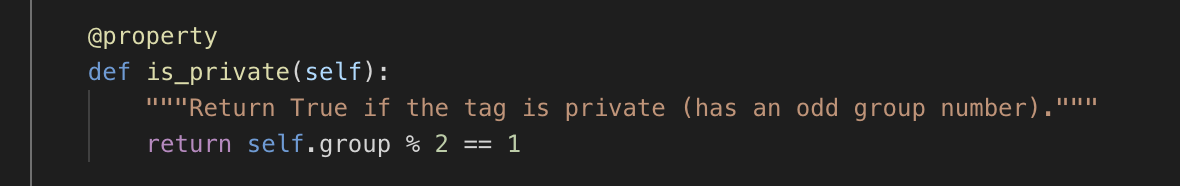

In [6]:
if 'OtherPatientIDs' in dataset:
    delattr(dataset, 'OtherPatientIDs')

if 'OtherPatientIDsSequence' in dataset:
    del dataset.OtherPatientIDsSequence

* 특정한 attribute가 dataset에 포함되어 있는 경우 삭제하는 방법

In [7]:
tag = 'PatientBirthDate'
if tag in dataset:
    dataset.data_element(tag).value = '01011900'

In [8]:
data_elements = ['PatientID',
                 'PatientBirthDate']
for de in data_elements:
    print(dataset.data_element(de))

output_filename = tempfile.NamedTemporaryFile().name
dataset.save_as(output_filename)

(0010, 0020) Patient ID                          LO: 'id'
(0010, 0030) Patient's Birth Date                DA: '01011900'


* 수정한 dataset을 저장하는 방법 (tempfile로 파일명 생성하고, save_as로 저장)